Method: real_8020
  Full set Mean R²: 0.6489
  Full set 95% CI: [0.6432, 0.6546]
  Low-freq (<1%) Mean R²: 0.2976
  Low-freq (<1%) 95% CI: [0.2856, 0.3095]
  Rare (<0.1%) Mean R²: 0.0886
  Rare (<0.1%) 95% CI: [0.0780, 0.0993]
Method: pc_real_8020
  Full set Mean R²: 0.5934
  Full set 95% CI: [0.5886, 0.5983]
  Low-freq (<1%) Mean R²: 0.2183
  Low-freq (<1%) 95% CI: [0.2083, 0.2282]
  Rare (<0.1%) Mean R²: 0.0529
  Rare (<0.1%) 95% CI: [0.0444, 0.0613]
Method: rbm_full
  Full set Mean R²: 0.5096
  Full set 95% CI: [0.5057, 0.5135]
  Low-freq (<1%) Mean R²: 0.0954
  Low-freq (<1%) 95% CI: [0.0875, 0.1033]
  Rare (<0.1%) Mean R²: 0.0119
  Rare (<0.1%) 95% CI: [0.0073, 0.0166]
Method: wgan_full
  Full set Mean R²: 0.4281
  Full set 95% CI: [0.4262, 0.4300]
  Low-freq (<1%) Mean R²: 0.0042
  Low-freq (<1%) 95% CI: [0.0035, 0.0050]
  Rare (<0.1%) Mean R²: 0.0001
  Rare (<0.1%) 95% CI: [0.0000, 0.0002]
Method: rbm_8020
  Full set Mean R²: 0.4936
  Full set 95% CI: [0.4910, 0.4963]
  Low-freq

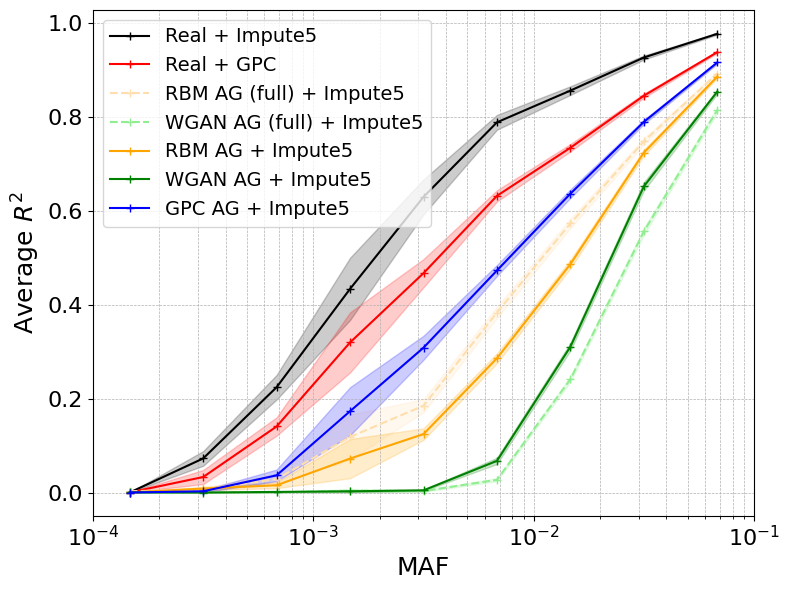

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

my_method_name = "GPC"

# --- Settings ---
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # For plotting

all_methods = ['real_8020', 'pc_real_8020', 'rbm_full', 'wgan_full', 'rbm_8020', 'wgan_8020', 'hclt_8020']
all_colors = ['black', 'r', 'navajowhite', 'lightgreen', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+', '+', '+']
all_labels = [
    'Real + Impute5', f'Real + {my_method_name}', 'RBM AG (full) + Impute5', 'WGAN AG (full) + Impute5',
    'RBM AG + Impute5', 'WGAN AG + Impute5', f'{my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '--', '--', '-', '-', '-']

# --- Function to summarize bootstrap statistics ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = overall_mean - 1.96 * sem
    ci_upper = overall_mean + 1.96 * sem
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_8020.csv')

    # Remove variants with MAF=0 upfront
    df = df[df['MAF'] > 0].copy()

    r2_cols = [c for c in df.columns if c.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)

    # Identify bootstrap columns
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]

    print(f"Method: {method}")

    # Full summary
    summarize_bootstrap(df, boot_cols, "Full set")

    # Low-frequency and rare subsets
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

    method_data[method] = df

# --- Plot each method with CI bands ---
plt.figure(figsize=(8,6))

for method_name, color, marker, label, linestyle in zip(all_methods, all_colors, all_markers, all_labels, all_linestyles):
    df = method_data[method_name]

    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]

    # Digitize MAFs into bins
    bin_indices = np.digitize(df['MAF'], bins) - 1

    mean_r2 = []
    ci_low = []
    ci_high = []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue
        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem
        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    mean_r2 = np.array(mean_r2)
    ci_low = np.array(ci_low)
    ci_high = np.array(ci_high)

    plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

# --- Plot formatting ---
plt.xscale('log')
plt.xticks([1e-4, 1e-3, 1e-2, 1e-1], [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('MAF', fontsize=18)
plt.ylabel(r'Average $R^2$', fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("results/plots/8020_bootstrap_ci.pdf", dpi=300, bbox_inches='tight')
plt.show()

Method: real_noneur
  Full set Mean R²: 0.4849
  Full set 95% CI: [0.4821, 0.4876]
  Low-freq (<1%) Mean R²: 0.1064
  Low-freq (<1%) 95% CI: [0.1006, 0.1123]
  Rare (<0.1%) Mean R²: 0.0205
  Rare (<0.1%) 95% CI: [0.0157, 0.0253]
Method: pc_real_noneur
  Full set Mean R²: 0.5626
  Full set 95% CI: [0.5609, 0.5644]
  Low-freq (<1%) Mean R²: 0.1584
  Low-freq (<1%) 95% CI: [0.1557, 0.1612]
  Rare (<0.1%) Mean R²: 0.0208
  Rare (<0.1%) 95% CI: [0.0159, 0.0258]
Method: pc_realeur_and_noneur_train_noneur
  Full set Mean R²: 0.5702
  Full set 95% CI: [0.5675, 0.5729]
  Low-freq (<1%) Mean R²: 0.1735
  Low-freq (<1%) 95% CI: [0.1687, 0.1782]
  Rare (<0.1%) Mean R²: 0.0305
  Rare (<0.1%) 95% CI: [0.0247, 0.0362]
Method: rbm_noneur
  Full set Mean R²: 0.4760
  Full set 95% CI: [0.4741, 0.4778]
  Low-freq (<1%) Mean R²: 0.0423
  Low-freq (<1%) 95% CI: [0.0391, 0.0455]
  Rare (<0.1%) Mean R²: 0.0028
  Rare (<0.1%) 95% CI: [0.0013, 0.0042]
Method: wgan_noneur
  Full set Mean R²: 0.4223
  Full set 9

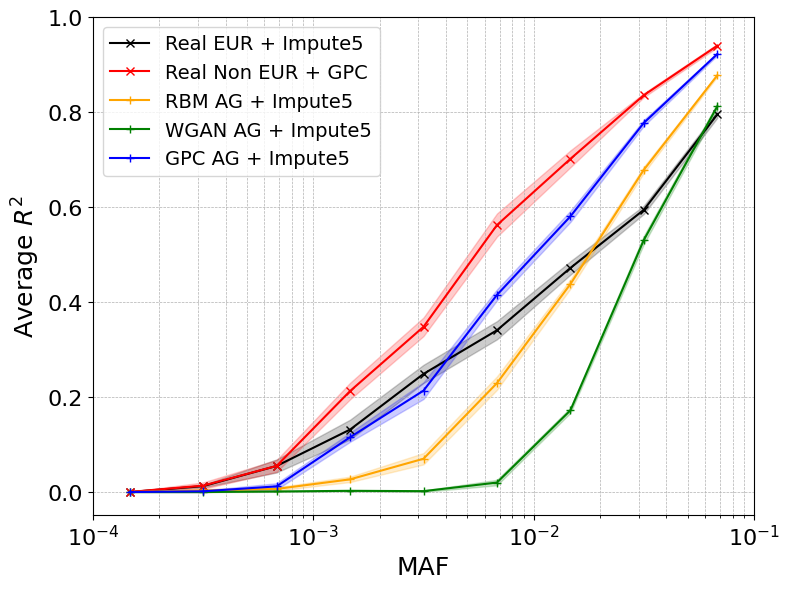

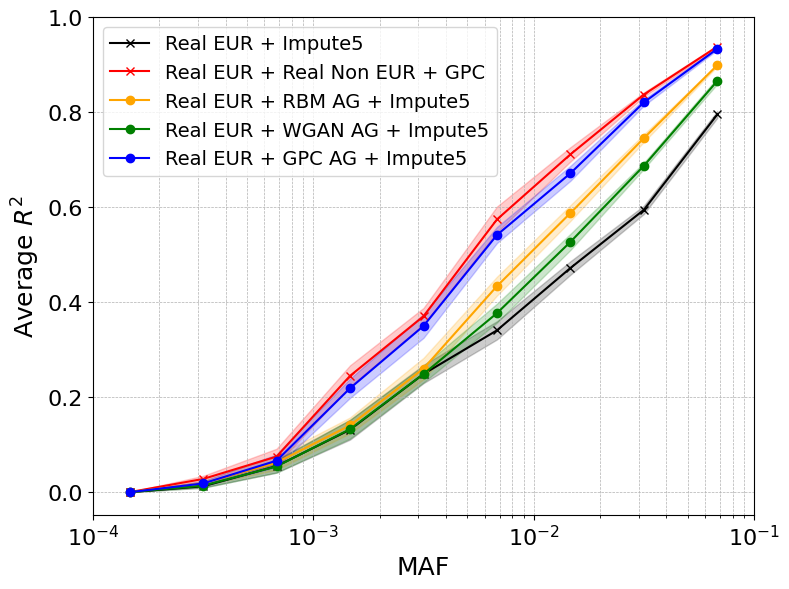

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

all_methods = [
    'real_noneur', 'pc_real_noneur', 'pc_realeur_and_noneur_train_noneur',
    'rbm_noneur', 'wgan_noneur', 'hclt_noneur',
    'rbm_noneur_combined', 'wgan_noneur_combined', 'hclt_noneur_combined'
]
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = [
    'Real EUR + Impute5', f'Real Non EUR + {my_method_name}', f'Real EUR + Real Non EUR + {my_method_name}',
    'RBM AG + Impute5', 'WGAN AG + Impute5', f'{my_method_name} AG + Impute5',
    'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', f'Real EUR + {my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

baseline_indices = [0, 1, 3, 4, 5]
combined_indices = [0, 2, 6, 7, 8]

# --- Function to summarize bootstrap stats ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = overall_mean - 1.96 * sem
    ci_upper = overall_mean + 1.96 * sem
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load and filter data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_noneur.csv')
    df = df[df['MAF'] > 0].copy()  # remove MAF=0 variants
    r2_cols = [c for c in df.columns if c.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]

    print(f"Method: {method}")
    summarize_bootstrap(df, boot_cols, "Full set")
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

    method_data[method] = df

# --- Plotting function ---
def plot_methods(indices, title, filename):
    fig, ax = plt.subplots(figsize=(8,6))
    for idx in indices:
        method_name = all_methods[idx]
        df = method_data[method_name]
        boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
        bin_indices = np.digitize(df['MAF'], bins) - 1

        mean_r2, ci_low, ci_high = [], [], []

        for i in range(num_bins):
            in_bin = bin_indices == i
            if not np.any(in_bin):
                mean_r2.append(np.nan)
                ci_low.append(np.nan)
                ci_high.append(np.nan)
                continue
            boot_values = df.loc[in_bin, boot_cols].values
            bin_means = np.nanmean(boot_values, axis=0)
            mean = np.mean(bin_means)
            sem = np.std(bin_means, ddof=1)
            ci = 1.96 * sem
            mean_r2.append(mean)
            ci_low.append(mean - ci)
            ci_high.append(mean + ci)

        mean_r2 = np.array(mean_r2)
        ci_low = np.array(ci_low)
        ci_high = np.array(ci_high)

        ax.plot(bin_centers, mean_r2, marker=all_markers[idx], linestyle=all_linestyles[idx],
                color=all_colors[idx], label=all_labels[idx])
        ax.fill_between(bin_centers, ci_low, ci_high, color=all_colors[idx], alpha=0.2)

    ax.set_xscale('log')
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylabel(r'Average $R^2$', fontsize=18)
    ax.set_xlabel('MAF', fontsize=18)
    # ax.set_title(title, fontsize=18)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Generate plots ---
plot_methods(baseline_indices, 'Non EUR AGs', 'results/plots/noneur_bootstrap_baseline.pdf')
plot_methods(combined_indices, 'Non EUR AGs + Real EUR', 'results/plots/noneur_bootstrap_combined.pdf')

Method: real_afr
  Full set Mean R²: 0.3678
  Full set 95% CI: [0.3572, 0.3785]
  Low-freq (<1%) Mean R²: 0.0188
  Low-freq (<1%) 95% CI: [0.0125, 0.0252]
  Rare (<0.1%) Mean R²: 0.0026
  Rare (<0.1%) 95% CI: [0.0006, 0.0045]
Method: pc_real_afr
  Full set Mean R²: 0.4620
  Full set 95% CI: [0.4557, 0.4682]
  Low-freq (<1%) Mean R²: 0.0429
  Low-freq (<1%) 95% CI: [0.0395, 0.0463]
  Rare (<0.1%) Mean R²: 0.0064
  Rare (<0.1%) 95% CI: [0.0048, 0.0079]
Method: pc_realeur_and_afr_train_afr
  Full set Mean R²: 0.4705
  Full set 95% CI: [0.4607, 0.4802]
  Low-freq (<1%) Mean R²: 0.0526
  Low-freq (<1%) 95% CI: [0.0464, 0.0587]
  Rare (<0.1%) Mean R²: 0.0071
  Rare (<0.1%) 95% CI: [0.0049, 0.0093]
Method: rbm_afr
  Full set Mean R²: 0.4288
  Full set 95% CI: [0.4238, 0.4338]
  Low-freq (<1%) Mean R²: 0.0275
  Low-freq (<1%) 95% CI: [0.0246, 0.0303]
  Rare (<0.1%) Mean R²: 0.0019
  Rare (<0.1%) 95% CI: [0.0005, 0.0034]
Method: wgan_afr
  Full set Mean R²: 0.3807
  Full set 95% CI: [0.3791, 0.

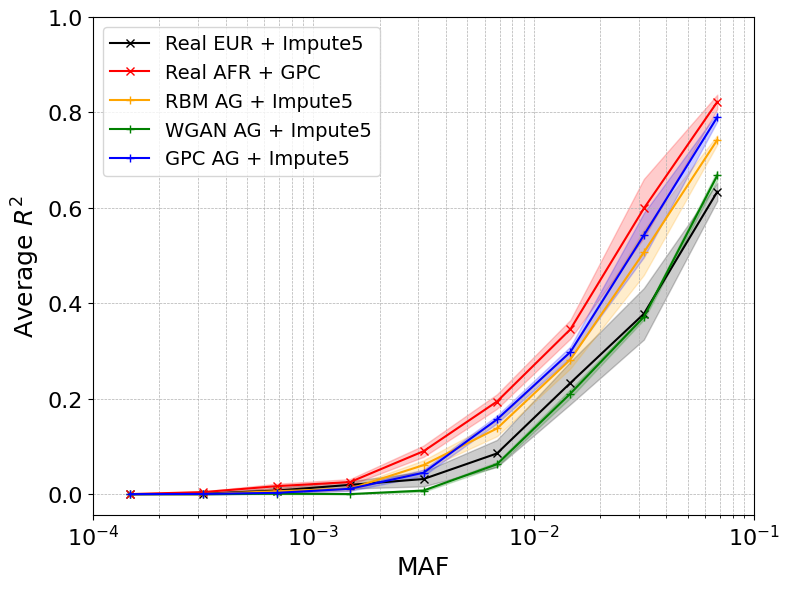

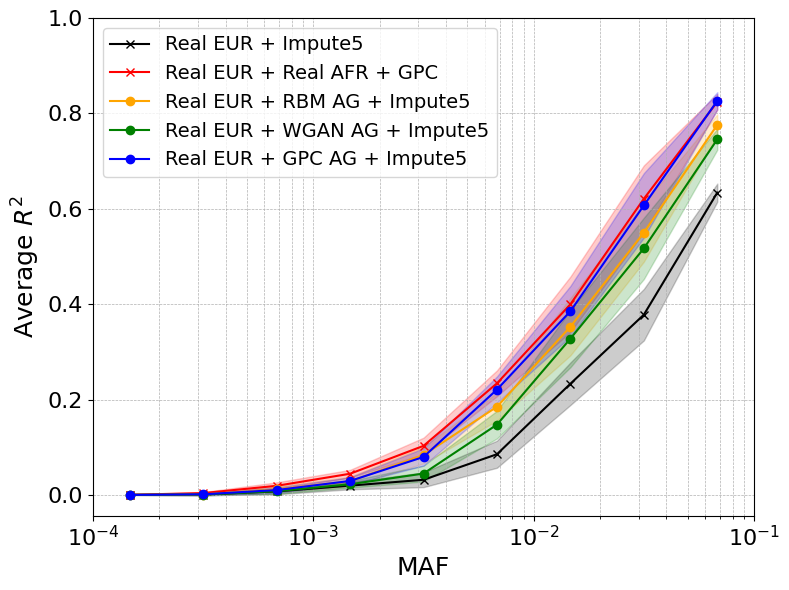

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

all_methods = [
    'real_afr', 'pc_real_afr', 'pc_realeur_and_afr_train_afr',
    'rbm_afr', 'wgan_afr', 'hclt_afr',
    'rbm_afr_combined', 'wgan_afr_combined', 'hclt_afr_combined'
]
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = [
    'Real EUR + Impute5', f'Real AFR + {my_method_name}', f'Real EUR + Real AFR + {my_method_name}',
    'RBM AG + Impute5', 'WGAN AG + Impute5', f'{my_method_name} AG + Impute5',
    'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', f'Real EUR + {my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

baseline_indices = [0, 1, 3, 4, 5]
combined_indices = [0, 2, 6, 7, 8]

# --- Function to summarize bootstrap stats ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = overall_mean - 1.96 * sem
    ci_upper = overall_mean + 1.96 * sem
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load and filter data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_afr.csv')
    df = df[df['MAF'] > 0].copy()  # remove MAF=0 variants
    r2_cols = [c for c in df.columns if c.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]

    print(f"Method: {method}")
    summarize_bootstrap(df, boot_cols, "Full set")
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

    method_data[method] = df

# --- Plotting function ---
def plot_methods(indices, title, filename):
    fig, ax = plt.subplots(figsize=(8,6))
    for idx in indices:
        method_name = all_methods[idx]
        df = method_data[method_name]
        boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
        bin_indices = np.digitize(df['MAF'], bins) - 1

        mean_r2, ci_low, ci_high = [], [], []

        for i in range(num_bins):
            in_bin = bin_indices == i
            if not np.any(in_bin):
                mean_r2.append(np.nan)
                ci_low.append(np.nan)
                ci_high.append(np.nan)
                continue
            boot_values = df.loc[in_bin, boot_cols].values
            bin_means = np.nanmean(boot_values, axis=0)
            mean = np.mean(bin_means)
            sem = np.std(bin_means, ddof=1)
            ci = 1.96 * sem
            mean_r2.append(mean)
            ci_low.append(mean - ci)
            ci_high.append(mean + ci)

        ax.plot(bin_centers, mean_r2, marker=all_markers[idx], linestyle=all_linestyles[idx],
                color=all_colors[idx], label=all_labels[idx])
        ax.fill_between(bin_centers, ci_low, ci_high, color=all_colors[idx], alpha=0.2)

    ax.set_xscale('log')
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylabel(r'Average $R^2$', fontsize=18)
    ax.set_xlabel('MAF', fontsize=18)
    # ax.set_title(title, fontsize=18)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Generate plots ---
plot_methods(baseline_indices, 'AFR AGs', 'results/plots/afr_bootstrap_baseline.pdf')
plot_methods(combined_indices, 'AFR AGs + Real EUR', 'results/plots/afr_bootstrap_combined.pdf')

Method: UKBB_real_8020
  Full set Mean R²: 0.9568
  Full set 95% CI: [0.9535, 0.9601]
  Low-freq (<1%) Mean R²: 0.9144
  Low-freq (<1%) 95% CI: [0.9072, 0.9217]
  Rare (<0.1%) Mean R²: 0.8178
  Rare (<0.1%) 95% CI: [0.7962, 0.8394]
Method: UKBB_pc_real_8020
  Full set Mean R²: 0.9063
  Full set 95% CI: [0.9033, 0.9093]
  Low-freq (<1%) Mean R²: 0.8283
  Low-freq (<1%) 95% CI: [0.8218, 0.8347]
  Rare (<0.1%) Mean R²: 0.7085
  Rare (<0.1%) 95% CI: [0.6873, 0.7297]
Method: UKBB_rbm_8020
  Full set Mean R²: 0.6685
  Full set 95% CI: [0.6668, 0.6703]
  Low-freq (<1%) Mean R²: 0.3806
  Low-freq (<1%) 95% CI: [0.3769, 0.3842]
  Rare (<0.1%) Mean R²: 0.1176
  Rare (<0.1%) 95% CI: [0.1117, 0.1234]
Method: UKBB_wgan_8020
  Full set Mean R²: 0.5231
  Full set 95% CI: [0.5224, 0.5238]
  Low-freq (<1%) Mean R²: 0.0869
  Low-freq (<1%) 95% CI: [0.0862, 0.0876]
  Rare (<0.1%) Mean R²: 0.0002
  Rare (<0.1%) 95% CI: [0.0001, 0.0003]
Method: UKBB_hclt_8020
  Full set Mean R²: 0.7499
  Full set 95% CI: [

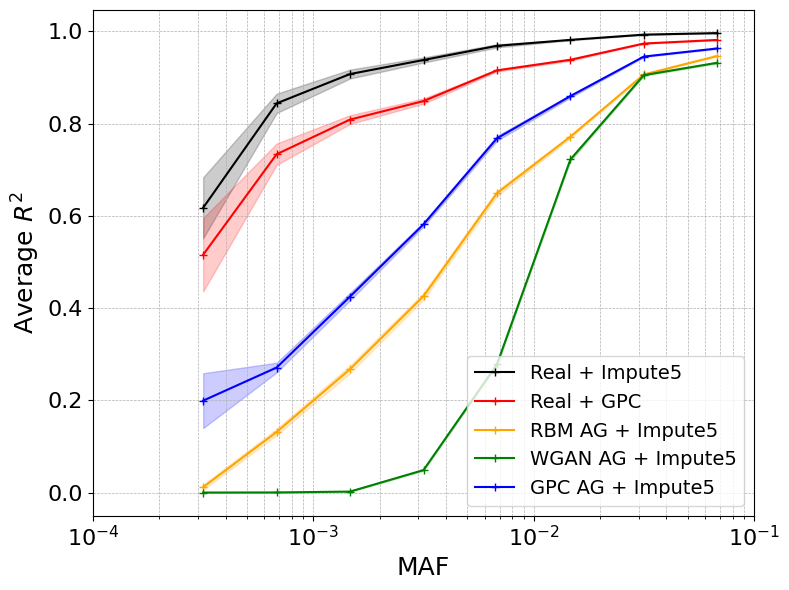

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])  # For plotting

all_methods = [
    'UKBB_real_8020', 'UKBB_pc_real_8020', 
    'UKBB_rbm_8020', 'UKBB_wgan_8020', 'UKBB_hclt_8020'
]
all_colors = ['black', 'r', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+']
all_labels = [
    'Real + Impute5', f'Real + {my_method_name}', 'RBM AG + Impute5', 
    'WGAN AG + Impute5', f'{my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-']

# --- Function to summarize bootstrap statistics ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = overall_mean - 1.96 * sem
    ci_upper = overall_mean + 1.96 * sem
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load and filter data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_bootstraps.csv')
    
    # Remove MAF=0 variants
    df = df[df['MAF'] > 0].copy()

    r2_cols = [col for col in df.columns if col.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
    
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
    
    print(f"Method: {method}")
    summarize_bootstrap(df, boot_cols, "Full set")
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")
    
    method_data[method] = df

# --- Plot each method with CI bands ---
plt.figure(figsize=(8,6))

for method_name, color, marker, label, linestyle in zip(
    all_methods, all_colors, all_markers, all_labels, all_linestyles
):
    df = method_data[method_name]
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
    bin_indices = np.digitize(df['MAF'], bins) - 1

    mean_r2 = []
    ci_low = []
    ci_high = []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        mean_r2.append(mean)
        ci_low.append(mean - ci)
        ci_high.append(mean + ci)

    plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

# --- Formatting ---
plt.xscale('log')
plt.xticks([1e-4, 1e-3, 1e-2, 1e-1], [r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('MAF', fontsize=18)
plt.ylabel(r'Average $R^2$', fontsize=18)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("results/plots/UKBB_8020_bootstrap_ci.pdf", dpi=300, bbox_inches='tight')
plt.show()

Method: UKBB_real_noneur
  Full set Mean R²: 0.7334
  Full set 95% CI: [0.7252, 0.7415]
  Low-freq (<1%) Mean R²: 0.5062
  Low-freq (<1%) 95% CI: [0.4908, 0.5217]
  Rare (<0.1%) Mean R²: 0.2110
  Rare (<0.1%) 95% CI: [0.1737, 0.2483]
Method: UKBB_pc_real_noneur
  Full set Mean R²: 0.7494
  Full set 95% CI: [0.7422, 0.7566]
  Low-freq (<1%) Mean R²: 0.4977
  Low-freq (<1%) 95% CI: [0.4827, 0.5128]
  Rare (<0.1%) Mean R²: 0.1587
  Rare (<0.1%) 95% CI: [0.1274, 0.1899]
Method: UKBB_pc_realeur_and_noneur_train
  Full set Mean R²: 0.7591
  Full set 95% CI: [0.7517, 0.7665]
  Low-freq (<1%) Mean R²: 0.5219
  Low-freq (<1%) 95% CI: [0.5067, 0.5371]
  Rare (<0.1%) Mean R²: 0.2103
  Rare (<0.1%) 95% CI: [0.1747, 0.2459]
Method: UKBB_rbm_noneur
  Full set Mean R²: 0.4950
  Full set 95% CI: [0.4926, 0.4974]
  Low-freq (<1%) Mean R²: 0.1277
  Low-freq (<1%) 95% CI: [0.1232, 0.1322]
  Rare (<0.1%) Mean R²: 0.0041
  Rare (<0.1%) 95% CI: [0.0025, 0.0058]
Method: UKBB_wgan_noneur
  Full set Mean R²: 0

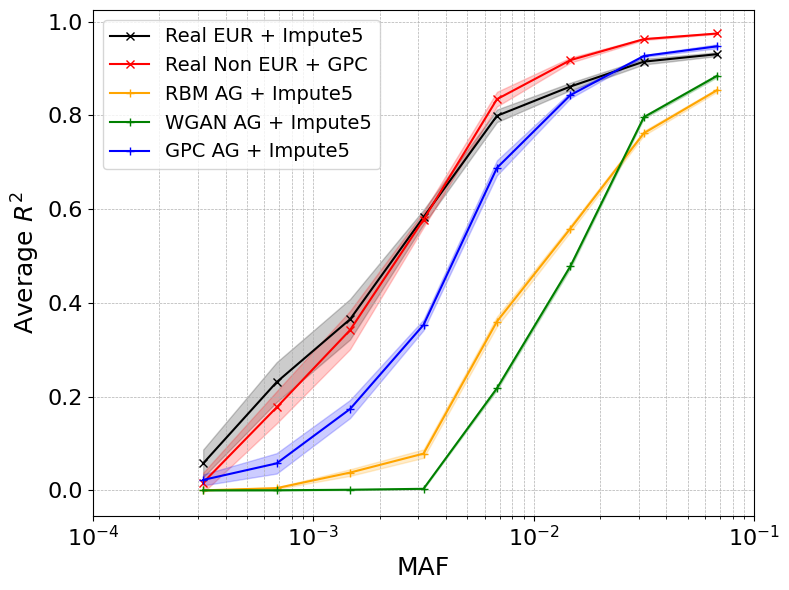

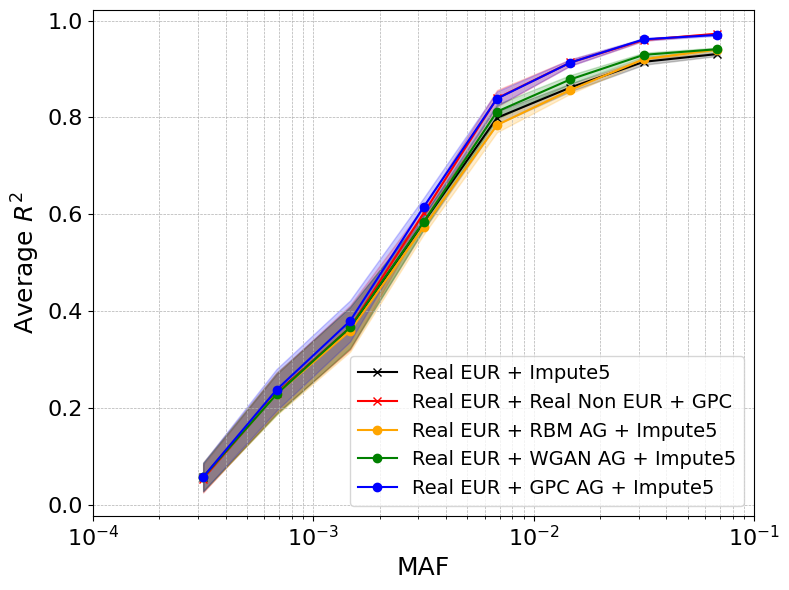

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

all_methods = [
    'UKBB_real_noneur', 'UKBB_pc_real_noneur', 'UKBB_pc_realeur_and_noneur_train',
    'UKBB_rbm_noneur', 'UKBB_wgan_noneur', 'UKBB_hclt_noneur',
    'UKBB_rbm_noneur_combined', 'UKBB_wgan_noneur_combined', 'UKBB_hclt_noneur_combined'
]
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = [
    'Real EUR + Impute5', f'Real Non EUR + {my_method_name}', f'Real EUR + Real Non EUR + {my_method_name}',
    'RBM AG + Impute5', 'WGAN AG + Impute5', f'{my_method_name} AG + Impute5',
    'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', f'Real EUR + {my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

baseline_indices = [0, 1, 3, 4, 5]
combined_indices = [0, 2, 6, 7, 8]

# --- Function to summarize bootstrap stats ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = overall_mean - 1.96 * sem
    ci_upper = overall_mean + 1.96 * sem
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load and filter data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_bootstraps.csv')
    df = df[df['MAF'] > 0].copy()  # remove MAF=0 variants
    r2_cols = [c for c in df.columns if c.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]

    print(f"Method: {method}")
    summarize_bootstrap(df, boot_cols, "Full set")
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

    method_data[method] = df

# --- Plotting function ---
def plot_methods(indices, title, filename):
    fig, ax = plt.subplots(figsize=(8,6))
    for idx in indices:
        method_name = all_methods[idx]
        df = method_data[method_name]
        boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
        bin_indices = np.digitize(df['MAF'], bins) - 1

        mean_r2, ci_low, ci_high = [], [], []

        for i in range(num_bins):
            in_bin = bin_indices == i
            if not np.any(in_bin):
                mean_r2.append(np.nan)
                ci_low.append(np.nan)
                ci_high.append(np.nan)
                continue
            boot_values = df.loc[in_bin, boot_cols].values
            bin_means = np.nanmean(boot_values, axis=0)
            mean = np.mean(bin_means)
            sem = np.std(bin_means, ddof=1)
            ci = 1.96 * sem
            mean_r2.append(mean)
            ci_low.append(mean - ci)
            ci_high.append(mean + ci)

        ax.plot(bin_centers, mean_r2, marker=all_markers[idx], linestyle=all_linestyles[idx],
                color=all_colors[idx], label=all_labels[idx])
        ax.fill_between(bin_centers, ci_low, ci_high, color=all_colors[idx], alpha=0.2)

    ax.set_xscale('log')
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylabel(r'Average $R^2$', fontsize=18)
    ax.set_xlabel('MAF', fontsize=18)
    # ax.set_title(title, fontsize=18)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Generate plots ---
plot_methods(baseline_indices, 'Non EUR AGs', 'results/plots/UKBB_noneur_bootstrap_baseline.pdf')
plot_methods(combined_indices, 'Non EUR AGs + Real EUR', 'results/plots/UKBB_noneur_bootstrap_combined.pdf')

Method: UKBB_real_afr
  Full set Mean R²: 0.6450
  Full set 95% CI: [0.6270, 0.6630]
  Low-freq (<1%) Mean R²: 0.3840
  Low-freq (<1%) 95% CI: [0.3539, 0.4140]
  Rare (<0.1%) Mean R²: 0.1150
  Rare (<0.1%) 95% CI: [0.0913, 0.1387]
Method: UKBB_pc_real_afr
  Full set Mean R²: 0.6786
  Full set 95% CI: [0.6628, 0.6944]
  Low-freq (<1%) Mean R²: 0.3636
  Low-freq (<1%) 95% CI: [0.3374, 0.3899]
  Rare (<0.1%) Mean R²: 0.0642
  Rare (<0.1%) 95% CI: [0.0507, 0.0777]
Method: UKBB_pc_realeur_and_afr_train
  Full set Mean R²: 0.6975
  Full set 95% CI: [0.6794, 0.7155]
  Low-freq (<1%) Mean R²: 0.4036
  Low-freq (<1%) 95% CI: [0.3730, 0.4342]
  Rare (<0.1%) Mean R²: 0.1107
  Rare (<0.1%) 95% CI: [0.0867, 0.1348]
Method: UKBB_rbm_afr
  Full set Mean R²: 0.4369
  Full set 95% CI: [0.4277, 0.4461]
  Low-freq (<1%) Mean R²: 0.0608
  Low-freq (<1%) 95% CI: [0.0518, 0.0698]
  Rare (<0.1%) Mean R²: 0.0007
  Rare (<0.1%) 95% CI: [0.0002, 0.0011]
Method: UKBB_wgan_afr
  Full set Mean R²: 0.3754
  Full se

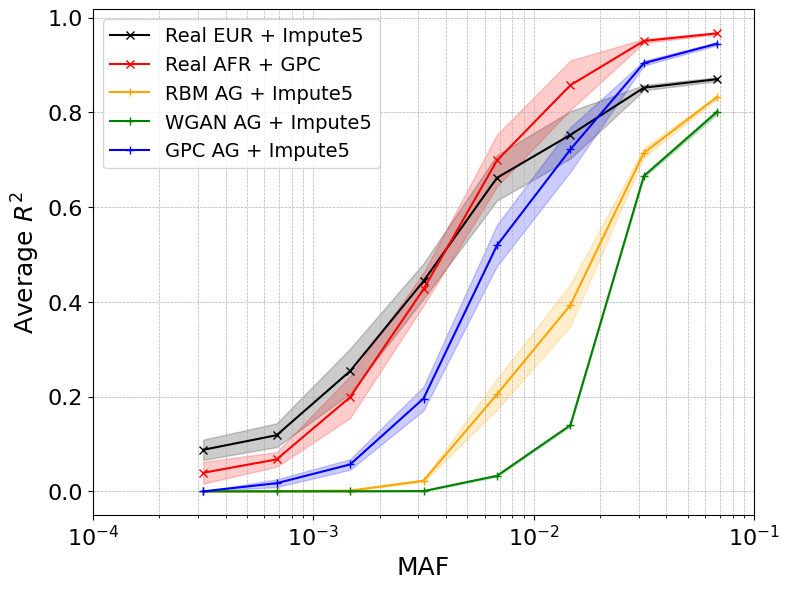

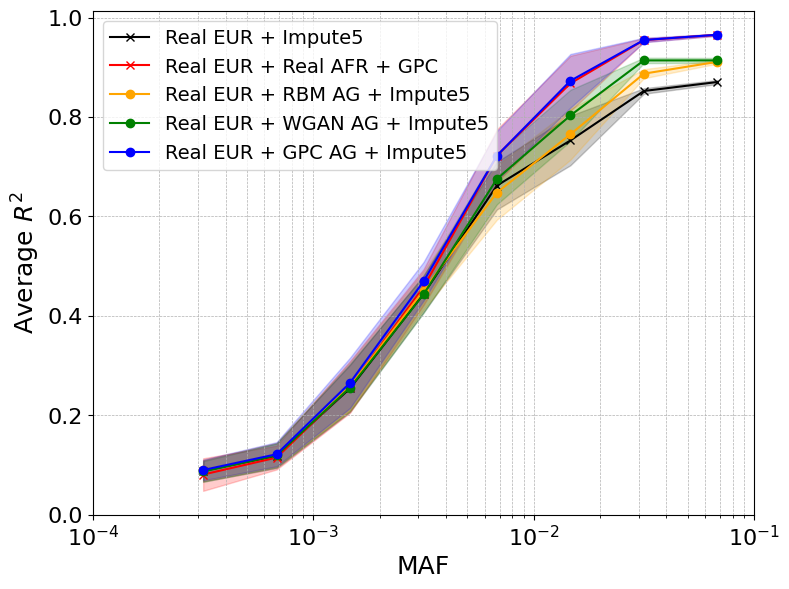

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9
bins = np.logspace(-4, -1, num_bins + 1)
bin_centers = np.sqrt(bins[:-1] * bins[1:])

all_methods = [
    'UKBB_real_afr', 'UKBB_pc_real_afr', 'UKBB_pc_realeur_and_afr_train',
    'UKBB_rbm_afr', 'UKBB_wgan_afr', 'UKBB_hclt_afr',
    'UKBB_rbm_afr_combined', 'UKBB_wgan_afr_combined', 'UKBB_hclt_afr_combined'
]
all_colors = ['black', 'r', 'r', 'orange', 'g', 'b', 'orange', 'g', 'b']
all_markers = ['x', 'x', 'x', '+', '+', '+', 'o', 'o', 'o']
all_labels = [
    'Real EUR + Impute5', f'Real AFR + {my_method_name}', f'Real EUR + Real AFR + {my_method_name}',
    'RBM AG + Impute5', 'WGAN AG + Impute5', f'{my_method_name} AG + Impute5',
    'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', f'Real EUR + {my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-', '-', '-', '-', '-']

baseline_indices = [0, 1, 3, 4, 5]
combined_indices = [0, 2, 6, 7, 8]

# --- Function to summarize bootstrap stats ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = overall_mean - 1.96 * sem
    ci_upper = overall_mean + 1.96 * sem
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load and filter data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/r2/{method}_bootstraps.csv')
    df = df[df['MAF'] > 0].copy()  # remove MAF=0 variants
    r2_cols = [c for c in df.columns if c.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]

    print(f"Method: {method}")
    summarize_bootstrap(df, boot_cols, "Full set")
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

    method_data[method] = df

# --- Plotting function ---
def plot_methods(indices, title, filename):
    fig, ax = plt.subplots(figsize=(8,6))
    for idx in indices:
        method_name = all_methods[idx]
        df = method_data[method_name]
        boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
        bin_indices = np.digitize(df['MAF'], bins) - 1

        mean_r2, ci_low, ci_high = [], [], []

        for i in range(num_bins):
            in_bin = bin_indices == i
            if not np.any(in_bin):
                mean_r2.append(np.nan)
                ci_low.append(np.nan)
                ci_high.append(np.nan)
                continue
            boot_values = df.loc[in_bin, boot_cols].values
            bin_means = np.nanmean(boot_values, axis=0)
            mean = np.mean(bin_means)
            sem = np.std(bin_means, ddof=1)
            ci = 1.96 * sem
            mean_r2.append(mean)
            ci_low.append(mean - ci)
            ci_high.append(mean + ci)

        ax.plot(bin_centers, mean_r2, marker=all_markers[idx], linestyle=all_linestyles[idx],
                color=all_colors[idx], label=all_labels[idx])
        ax.fill_between(bin_centers, ci_low, ci_high, color=all_colors[idx], alpha=0.2)

    ax.set_xscale('log')
    ax.set_xticks([1e-4, 1e-3, 1e-2, 1e-1])
    ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.tick_params(axis='both', labelsize=16)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.set_ylabel(r'Average $R^2$', fontsize=18)
    ax.set_xlabel('MAF', fontsize=18)
    # ax.set_title(title, fontsize=18)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Generate plots ---
plot_methods(baseline_indices, 'AFR AGs', 'results/plots/UKBB_afr_bootstrap_baseline.pdf')
plot_methods(combined_indices, 'AFR AGs + Real EUR', 'results/plots/UKBB_afr_bootstrap_combined.pdf')

Method: real
  Full set Mean R²: 0.7493
  Full set 95% CI: [0.7453, 0.7532]
  Low-freq (<1%) Mean R²: 0.6255
  Low-freq (<1%) 95% CI: [0.6177, 0.6333]
  Rare (<0.1%): No data
Method: pc
  Full set Mean R²: 0.5936
  Full set 95% CI: [0.5894, 0.5978]
  Low-freq (<1%) Mean R²: 0.3439
  Low-freq (<1%) 95% CI: [0.3354, 0.3523]
  Rare (<0.1%): No data
Method: rbm
  Full set Mean R²: 0.5736
  Full set 95% CI: [0.5696, 0.5777]
  Low-freq (<1%) Mean R²: 0.3009
  Low-freq (<1%) 95% CI: [0.2897, 0.3121]
  Rare (<0.1%): No data
Method: wgan
  Full set Mean R²: 0.4740
  Full set 95% CI: [0.4717, 0.4763]
  Low-freq (<1%) Mean R²: 0.1195
  Low-freq (<1%) 95% CI: [0.1158, 0.1232]
  Rare (<0.1%): No data
Method: hclt
  Full set Mean R²: 0.5147
  Full set 95% CI: [0.5114, 0.5180]
  Low-freq (<1%) Mean R²: 0.2151
  Low-freq (<1%) 95% CI: [0.2086, 0.2217]
  Rare (<0.1%): No data


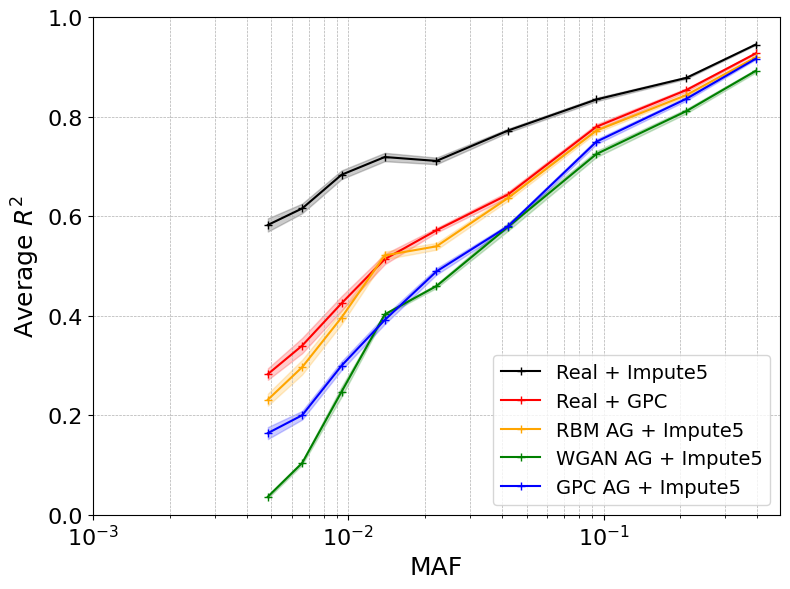

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9  # desired number of bins
all_methods = ['real', 'pc', 'rbm', 'wgan', 'hclt']
all_colors = ['black', 'r', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+']
all_labels = [
    'Real + Impute5', f'Real + {my_method_name}', 'RBM AG + Impute5', 
    'WGAN AG + Impute5', f'{my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-']

# --- Function to summarize bootstrap statistics ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = max(overall_mean - 1.96 * sem, 0)
    ci_upper = min(overall_mean + 1.96 * sem, 1)
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Load and filter data ---
method_data = {}
for method in all_methods:
    df = pd.read_csv(f'results/multi/8020_multi_{method}_b38_hum5_chr15_results.csv')
    
    # Remove MAF=0 variants
    df = df[df['MAF'] > 0].copy()
    df = df.reset_index(drop=True)

    # Fill missing R2 values
    r2_cols = [col for col in df.columns if col.startswith("R2")]
    df[r2_cols] = df[r2_cols].fillna(0)
    
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
    
    print(f"Method: {method}")
    summarize_bootstrap(df, boot_cols, "Full set")
    summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
    summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")
    
    method_data[method] = df

# --- Compute equal-count bins based on MAF ---
# Using quantiles ensures roughly equal SNP counts per bin
bin_edges = np.quantile(pd.concat([df['MAF'] for df in method_data.values()]), 
                        np.linspace(0, 1, num_bins + 1))
bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])  # geometric mean for log-style plot

# --- Plot each method with CI bands ---
plt.figure(figsize=(8,6))

for method_name, color, marker, label, linestyle in zip(
    all_methods, all_colors, all_markers, all_labels, all_linestyles
):
    df = method_data[method_name]
    boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
    
    # Assign bins
    bin_indices = np.digitize(df['MAF'], bin_edges) - 1
    bin_indices[bin_indices == num_bins] = num_bins - 1  # edge case

    mean_r2 = []
    ci_low = []
    ci_high = []

    for i in range(num_bins):
        in_bin = bin_indices == i
        if not np.any(in_bin):
            mean_r2.append(np.nan)
            ci_low.append(np.nan)
            ci_high.append(np.nan)
            continue

        # bootstrap values for this bin
        boot_values = df.loc[in_bin, boot_cols].values
        bin_means = np.nanmean(boot_values, axis=0)
        mean = np.mean(bin_means)
        sem = np.std(bin_means, ddof=1)
        ci = 1.96 * sem

        # clip CI to [0,1]
        mean_r2.append(mean)
        ci_low.append(max(mean - ci, 0))
        ci_high.append(min(mean + ci, 1))

    plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
    plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

# --- Formatting ---
plt.xscale('log')
plt.xticks([1e-3, 1e-2, 1e-1], [r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('MAF', fontsize=18)
plt.ylabel(r'Average $R^2$', fontsize=18)
plt.ylim(0,1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("results/plots/b38_8020_multi_bootstrap_ci.pdf", dpi=300, bbox_inches='tight')
plt.show()

Method: realeur
  Full set Mean R²: 0.3384
  Full set 95% CI: [0.3354, 0.3415]
  Low-freq (<1%) Mean R²: 0.0457
  Low-freq (<1%) 95% CI: [0.0423, 0.0490]
  Rare (<0.1%): No data
Method: pc
  Full set Mean R²: 0.5933
  Full set 95% CI: [0.5903, 0.5962]
  Low-freq (<1%) Mean R²: 0.3391
  Low-freq (<1%) 95% CI: [0.3348, 0.3435]
  Rare (<0.1%): No data
Method: rbm
  Full set Mean R²: 0.5648
  Full set 95% CI: [0.5615, 0.5681]
  Low-freq (<1%) Mean R²: 0.2955
  Low-freq (<1%) 95% CI: [0.2874, 0.3037]
  Rare (<0.1%): No data
Method: wgan
  Full set Mean R²: 0.4623
  Full set 95% CI: [0.4587, 0.4659]
  Low-freq (<1%) Mean R²: 0.1137
  Low-freq (<1%) 95% CI: [0.1117, 0.1156]
  Rare (<0.1%): No data
Method: hclt
  Full set Mean R²: 0.5292
  Full set 95% CI: [0.5271, 0.5314]
  Low-freq (<1%) Mean R²: 0.2371
  Low-freq (<1%) 95% CI: [0.2344, 0.2397]
  Rare (<0.1%): No data


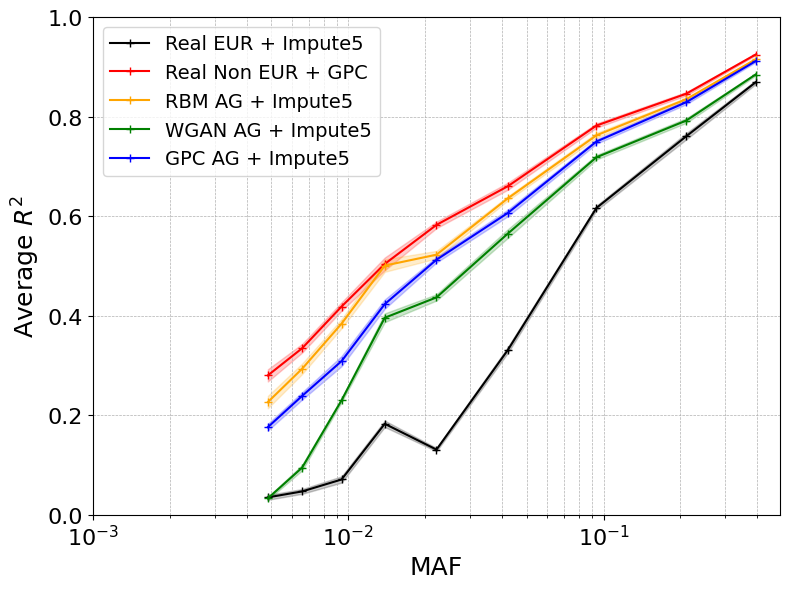

Method: realeur_combined
  Full set Mean R²: 0.3384
  Full set 95% CI: [0.3354, 0.3415]
  Low-freq (<1%) Mean R²: 0.0457
  Low-freq (<1%) 95% CI: [0.0423, 0.0490]
  Rare (<0.1%): No data
Method: pc_combined
  Full set Mean R²: 0.5835
  Full set 95% CI: [0.5805, 0.5864]
  Low-freq (<1%) Mean R²: 0.3306
  Low-freq (<1%) 95% CI: [0.3231, 0.3382]
  Rare (<0.1%): No data
Method: rbm_combined
  Full set Mean R²: 0.5838
  Full set 95% CI: [0.5800, 0.5877]
  Low-freq (<1%) Mean R²: 0.3288
  Low-freq (<1%) 95% CI: [0.3206, 0.3370]
  Rare (<0.1%): No data
Method: wgan_combined
  Full set Mean R²: 0.4944
  Full set 95% CI: [0.4894, 0.4993]
  Low-freq (<1%) Mean R²: 0.1619
  Low-freq (<1%) 95% CI: [0.1550, 0.1688]
  Rare (<0.1%): No data
Method: hclt_combined
  Full set Mean R²: 0.5481
  Full set 95% CI: [0.5445, 0.5518]
  Low-freq (<1%) Mean R²: 0.2656
  Low-freq (<1%) 95% CI: [0.2555, 0.2757]
  Rare (<0.1%): No data


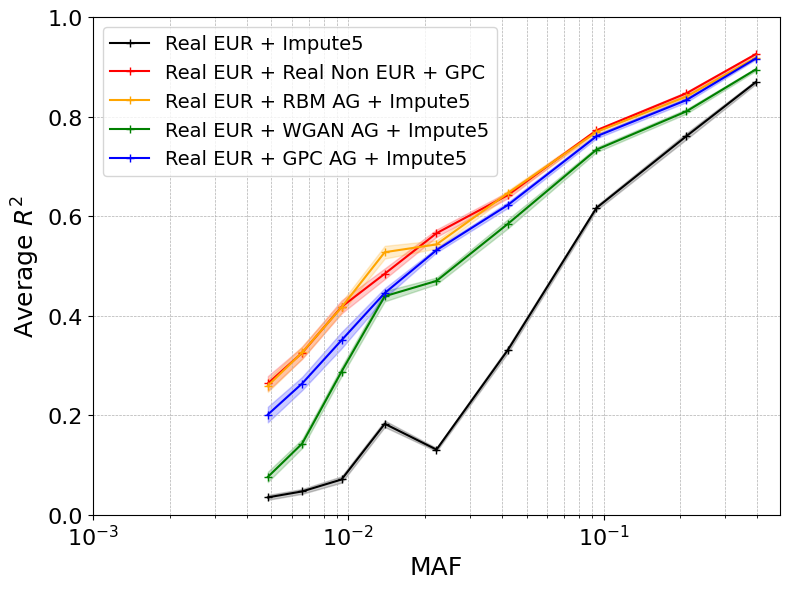

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9  # desired number of bins
all_methods = ['realeur', 'pc', 'rbm', 'wgan', 'hclt']
all_colors = ['black', 'r', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+']
all_labels = [
    'Real EUR + Impute5', f'Real Non EUR + {my_method_name}', 'RBM AG + Impute5', 
    'WGAN AG + Impute5', f'{my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-']

# --- Function to summarize bootstrap statistics ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = max(overall_mean - 1.96 * sem, 0)
    ci_upper = min(overall_mean + 1.96 * sem, 1)
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Function to load data ---
def load_method_data(method_names, prefix="noneur", suffix=""):
    method_data = {}
    for method in method_names:
        if method == 'realeur':
            filename = f'results/multi/{prefix}_multi_{method}_b38_hum5_chr15_results.csv'
        else:
            filename = f'results/multi/{prefix}_multi_{method}{suffix}_b38_hum5_chr15_results.csv'
        df = pd.read_csv(filename)
        df = df[df['MAF'] > 0].copy()
        df = df.reset_index(drop=True)

        r2_cols = [col for col in df.columns if col.startswith("R2")]
        df[r2_cols] = df[r2_cols].fillna(0)
        boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

        print(f"Method: {method}{suffix}")
        summarize_bootstrap(df, boot_cols, "Full set")
        summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
        summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

        method_data[method] = df
    return method_data

# --- Compute bin edges ---
def compute_bin_edges(method_data, num_bins):
    all_maf = pd.concat([df['MAF'] for df in method_data.values()])
    bin_edges = np.quantile(all_maf, np.linspace(0, 1, num_bins + 1))
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    return bin_edges, bin_centers

# --- Plotting function ---
def plot_bootstrap(method_data, bin_edges, bin_centers, title, savefile, labels=None):
    if labels is None:
        labels = all_labels
    plt.figure(figsize=(8,6))
    for method_name, color, marker, label, linestyle in zip(
        all_methods, all_colors, all_markers, labels, all_linestyles
    ):
        df = method_data[method_name]
        boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
        bin_indices = np.digitize(df['MAF'], bin_edges) - 1
        bin_indices[bin_indices == num_bins] = num_bins - 1

        mean_r2, ci_low, ci_high = [], [], []
        for i in range(num_bins):
            in_bin = bin_indices == i
            if not np.any(in_bin):
                mean_r2.append(np.nan)
                ci_low.append(np.nan)
                ci_high.append(np.nan)
                continue
            boot_values = df.loc[in_bin, boot_cols].values
            bin_means = np.nanmean(boot_values, axis=0)
            mean = np.mean(bin_means)
            sem = np.std(bin_means, ddof=1)
            ci = 1.96 * sem
            mean_r2.append(mean)
            ci_low.append(max(mean - ci, 0))
            ci_high.append(min(mean + ci, 1))

        plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
        plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

    plt.xscale('log')
    plt.xticks([1e-3, 1e-2, 1e-1], [r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('MAF', fontsize=18)
    plt.ylabel(r'Average $R^2$', fontsize=18)
    plt.ylim(0,1)
    # plt.title(title, fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(savefile, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Original Non-EUR plot ---
method_data = load_method_data(all_methods, prefix="noneur")
bin_edges, bin_centers = compute_bin_edges(method_data, num_bins)
plot_bootstrap(method_data, bin_edges, bin_centers, "Non EUR AGs", "results/plots/b38_noneur_multi_bootstrap_ci.pdf")

# --- Combined Non-EUR plot ---
method_data_combined = load_method_data(all_methods, prefix="noneur", suffix="_combined")
bin_edges_combined, bin_centers_combined = compute_bin_edges(method_data_combined, num_bins)
plot_bootstrap(method_data_combined, bin_edges_combined, bin_centers_combined,
               "Non EUR AGs + Real EUR",
               "results/plots/b38_noneur_multi_bootstrap_ci_combined.pdf",
               labels=['Real EUR + Impute5', f'Real EUR + Real Non EUR + {my_method_name}', 'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', f'Real EUR + {my_method_name} AG + Impute5'])


Method: realeur
  Full set Mean R²: 0.2683
  Full set 95% CI: [0.2639, 0.2726]
  Low-freq (<1%) Mean R²: 0.0219
  Low-freq (<1%) 95% CI: [0.0170, 0.0268]
  Rare (<0.1%): No data
Method: pc
  Full set Mean R²: 0.5825
  Full set 95% CI: [0.5741, 0.5908]
  Low-freq (<1%) Mean R²: 0.3755
  Low-freq (<1%) 95% CI: [0.3549, 0.3961]
  Rare (<0.1%): No data
Method: rbm
  Full set Mean R²: 0.5521
  Full set 95% CI: [0.5425, 0.5616]
  Low-freq (<1%) Mean R²: 0.3392
  Low-freq (<1%) 95% CI: [0.3195, 0.3589]
  Rare (<0.1%): No data
Method: wgan
  Full set Mean R²: 0.3672
  Full set 95% CI: [0.3633, 0.3711]
  Low-freq (<1%) Mean R²: 0.0819
  Low-freq (<1%) 95% CI: [0.0778, 0.0859]
  Rare (<0.1%): No data
Method: hclt
  Full set Mean R²: 0.5456
  Full set 95% CI: [0.5388, 0.5524]
  Low-freq (<1%) Mean R²: 0.3168
  Low-freq (<1%) 95% CI: [0.2994, 0.3342]
  Rare (<0.1%): No data


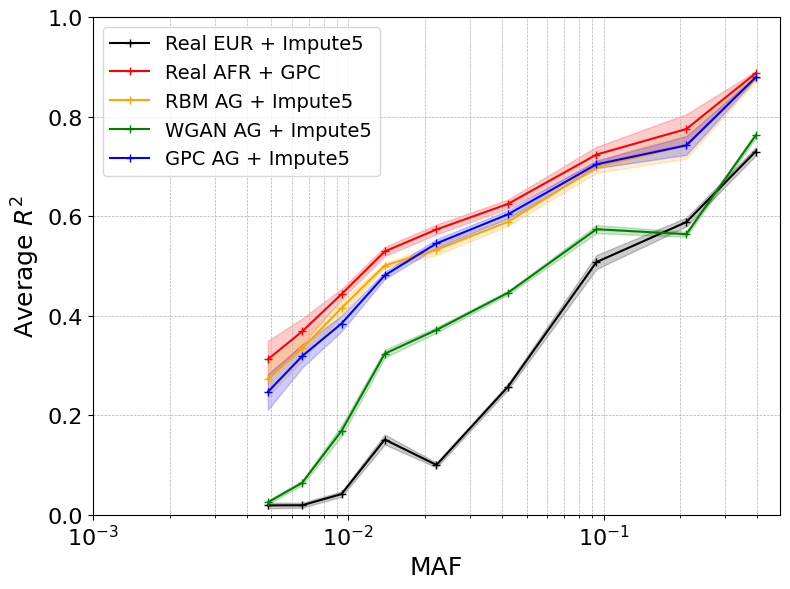

Method: realeur_combined
  Full set Mean R²: 0.2683
  Full set 95% CI: [0.2639, 0.2726]
  Low-freq (<1%) Mean R²: 0.0219
  Low-freq (<1%) 95% CI: [0.0170, 0.0268]
  Rare (<0.1%): No data
Method: pc_combined
  Full set Mean R²: 0.5616
  Full set 95% CI: [0.5523, 0.5708]
  Low-freq (<1%) Mean R²: 0.3415
  Low-freq (<1%) 95% CI: [0.3200, 0.3630]
  Rare (<0.1%): No data
Method: rbm_combined
  Full set Mean R²: 0.5631
  Full set 95% CI: [0.5526, 0.5736]
  Low-freq (<1%) Mean R²: 0.3502
  Low-freq (<1%) 95% CI: [0.3299, 0.3705]
  Rare (<0.1%): No data
Method: wgan_combined
  Full set Mean R²: 0.4069
  Full set 95% CI: [0.3984, 0.4155]
  Low-freq (<1%) Mean R²: 0.1014
  Low-freq (<1%) 95% CI: [0.0927, 0.1101]
  Rare (<0.1%): No data
Method: hclt_combined
  Full set Mean R²: 0.5562
  Full set 95% CI: [0.5483, 0.5642]
  Low-freq (<1%) Mean R²: 0.3253
  Low-freq (<1%) 95% CI: [0.3070, 0.3435]
  Rare (<0.1%): No data


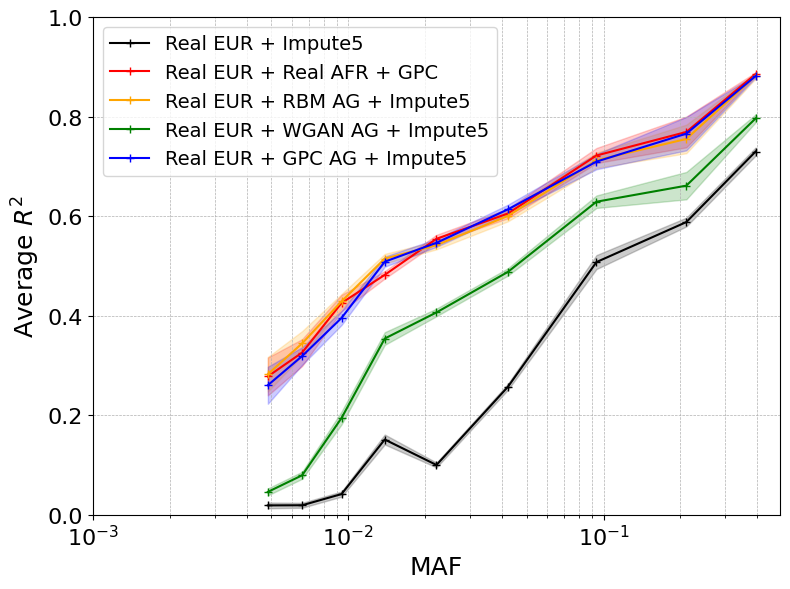

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Settings ---
num_bins = 9  # desired number of bins
all_methods = ['realeur', 'pc', 'rbm', 'wgan', 'hclt']
all_colors = ['black', 'r', 'orange', 'g', 'b']
all_markers = ['+', '+', '+', '+', '+']
all_labels = [
    'Real EUR + Impute5', f'Real AFR + {my_method_name}', 'RBM AG + Impute5', 
    'WGAN AG + Impute5', f'{my_method_name} AG + Impute5'
]
all_linestyles = ['-', '-', '-', '-', '-']

# --- Function to summarize bootstrap statistics ---
def summarize_bootstrap(df_subset, boot_cols, label):
    if df_subset.empty:
        print(f"  {label}: No data")
        return
    bootstrap_means = df_subset[boot_cols].mean(skipna=True)
    overall_mean = bootstrap_means.mean()
    sem = bootstrap_means.std(ddof=1)
    ci_lower = max(overall_mean - 1.96 * sem, 0)
    ci_upper = min(overall_mean + 1.96 * sem, 1)
    print(f"  {label} Mean R²: {overall_mean:.4f}")
    print(f"  {label} 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Function to load data ---
def load_method_data(method_names, suffix=""):
    method_data = {}
    for method in method_names:
        if method == 'realeur':
            filename = f'results/multi/afr_multi_{method}_b38_hum5_chr15_results.csv'
        else:
            filename = f'results/multi/afr_multi_{method}{suffix}_b38_hum5_chr15_results.csv'
        df = pd.read_csv(filename)
        df = df[df['MAF'] > 0].copy()
        df = df.reset_index(drop=True)

        r2_cols = [col for col in df.columns if col.startswith("R2")]
        df[r2_cols] = df[r2_cols].fillna(0)
        boot_cols = [col for col in df.columns if col.startswith('R2_boot_')]

        print(f"Method: {method}{suffix}")
        summarize_bootstrap(df, boot_cols, "Full set")
        summarize_bootstrap(df[df['MAF'] < 0.01], boot_cols, "Low-freq (<1%)")
        summarize_bootstrap(df[df['MAF'] < 0.001], boot_cols, "Rare (<0.1%)")

        method_data[method] = df
    return method_data

# --- Compute bin edges from all methods ---
def compute_bin_edges(method_data, num_bins):
    all_maf = pd.concat([df['MAF'] for df in method_data.values()])
    bin_edges = np.quantile(all_maf, np.linspace(0, 1, num_bins + 1))
    bin_centers = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    return bin_edges, bin_centers

# --- Plotting function ---
def plot_bootstrap(method_data, bin_edges, bin_centers, title, savefile, labels=None):
    if labels is None:
        labels = all_labels
    plt.figure(figsize=(8,6))
    for method_name, color, marker, label, linestyle in zip(
        all_methods, all_colors, all_markers, labels, all_linestyles
    ):
        df = method_data[method_name]
        boot_cols = [c for c in df.columns if c.startswith('R2_boot_')]
        bin_indices = np.digitize(df['MAF'], bin_edges) - 1
        bin_indices[bin_indices == num_bins] = num_bins - 1

        mean_r2, ci_low, ci_high = [], [], []
        for i in range(num_bins):
            in_bin = bin_indices == i
            if not np.any(in_bin):
                mean_r2.append(np.nan)
                ci_low.append(np.nan)
                ci_high.append(np.nan)
                continue
            boot_values = df.loc[in_bin, boot_cols].values
            bin_means = np.nanmean(boot_values, axis=0)
            mean = np.mean(bin_means)
            sem = np.std(bin_means, ddof=1)
            ci = 1.96 * sem
            mean_r2.append(mean)
            ci_low.append(max(mean - ci, 0))
            ci_high.append(min(mean + ci, 1))

        plt.plot(bin_centers, mean_r2, marker=marker, linestyle=linestyle, color=color, label=label)
        plt.fill_between(bin_centers, ci_low, ci_high, color=color, alpha=0.2)

    plt.xscale('log')
    plt.xticks([1e-3, 1e-2, 1e-1], [r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"], fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('MAF', fontsize=18)
    plt.ylabel(r'Average $R^2$', fontsize=18)
    plt.ylim(0,1)
    # plt.title(title, fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(savefile, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# --- Original plot ---
method_data = load_method_data(all_methods)
bin_edges, bin_centers = compute_bin_edges(method_data, num_bins)
plot_bootstrap(method_data, bin_edges, bin_centers, "AFR AGs", "results/plots/b38_afr_multi_bootstrap_ci.pdf")

# --- Combined plot ---
method_data_combined = load_method_data(all_methods, suffix="_combined")
bin_edges_combined, bin_centers_combined = compute_bin_edges(method_data_combined, num_bins)
plot_bootstrap(method_data_combined, bin_edges_combined, bin_centers_combined,
               "AFR AGs + Real EUR",
               "results/plots/b38_afr_multi_bootstrap_ci_combined.pdf",
               labels=['Real EUR + Impute5', f'Real EUR + Real AFR + {my_method_name}', 'Real EUR + RBM AG + Impute5', 'Real EUR + WGAN AG + Impute5', f'Real EUR + {my_method_name} AG + Impute5'])
